In [1]:
%matplotlib tk
import numpy as np, scipy.stats
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib import pyplot as plot

# Sorting Dates

## When has the underlying population changed, and you need to adapt?

## Background

In the 80’s I was part of an effort to build a machine to sort date fruit, a boring task for humans but critical in QA. I left the project after securing a budget and setting up a lab for hardware/software development. The machine eventually got built and was used in production for a few years until it became technologically obsolete.

## The Machine

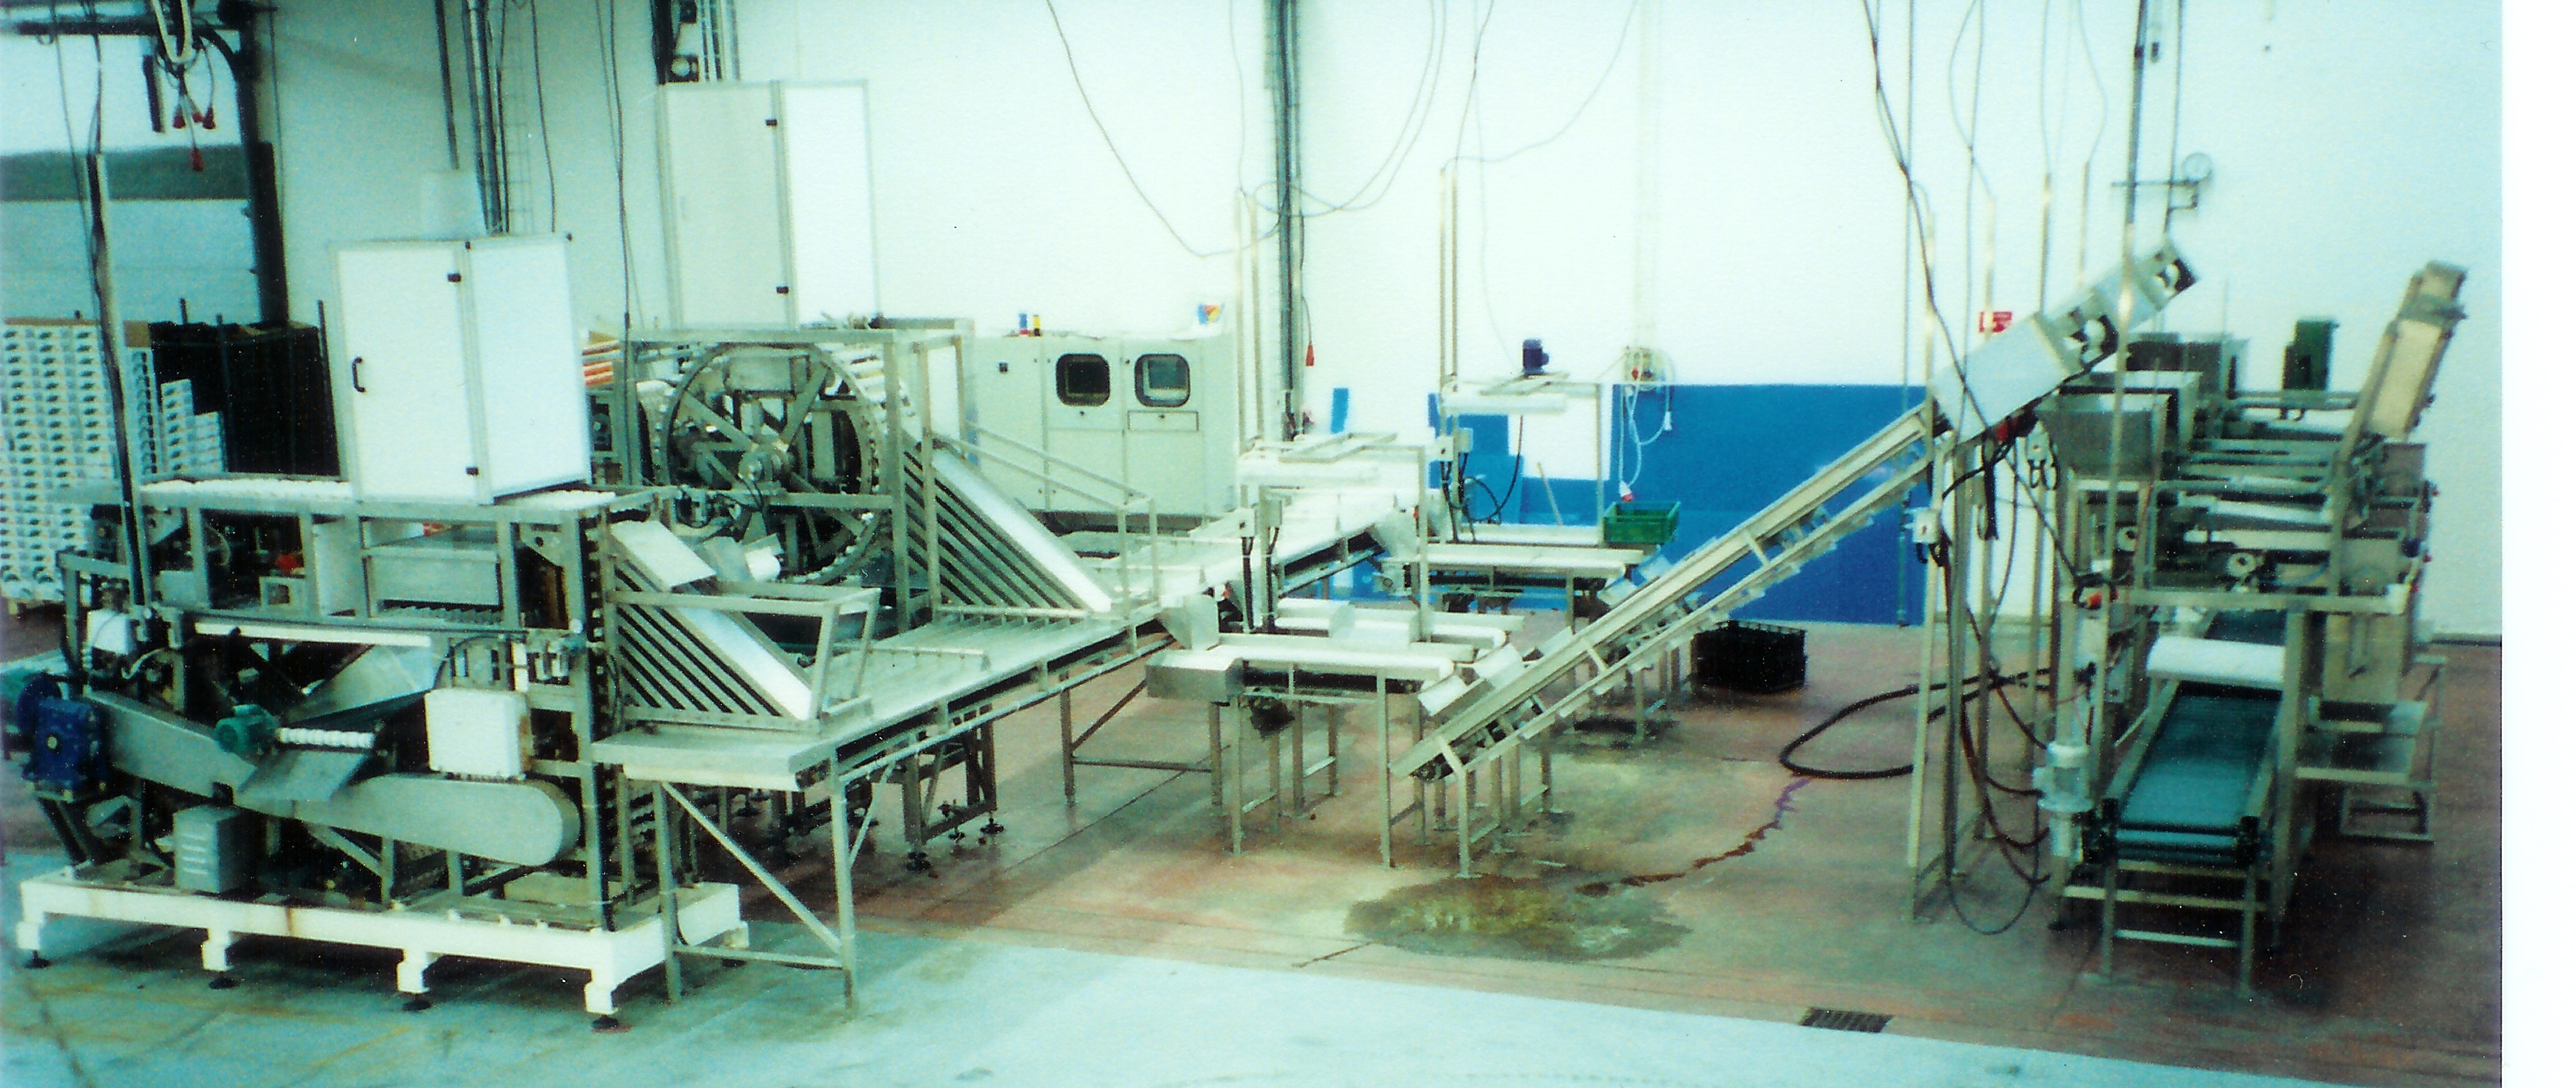

## Populations

The machine would sort thousands of dates an hour, dividing them into Grade A (premium price, export) Grade B (local market) and Grade C (not marketable, used for industrial products). We collected data and trained classifiers on 7 features. But we noticed dates from different orchards had different optimal classifiers. We needed a method to detect and switch classifiers when the produce stream (the population) came from a different orchard.

## Problem Statement

Given a stream of data, detect a when the data’s source is from a different population, and choose the optimal classifier for that new population.

This became my doctorate.

In [3]:
## 1-d simulation

# Draw 1000 samples from a normal distribution with mean 0, std 2
# Draw 1000 samples from a normal distribution with mean 1, std 1.5.
# How to detect the change?
x = np.empty((2000, 2), dtype=float)
y = np.empty((2000), dtype=float)
x[:1000, 0] = 0
x[:1000, 1] = 2
x[1000:, 0] = 1
x[1000:, 1] = 1.5
y[:1000] = np.random.normal(0, 2, 1000)
y[1000:] = np.random.normal(1, 1.5, 1000)
fig, axes = plot.subplots(1,1, figsize=(12,8))
axes.plot(y, 'y', label='samples')
axes.plot(x[:, 0], label='mean')
axes.plot(x[:, 1], label = 'std')

# Now add the theoretical and actual CDF (for a certain window)to the plot
s = np.linspace(-6, 6, 1000)
cdf_t1 = scipy.stats.norm.cdf(s, 0, 2)
cdf_t2 = scipy.stats.norm.cdf(s, 1, 1.5)
h = [axes.plot(s * 50 + 100, cdf_t1 * 5, 'r', label='cdf 1')[0],
     axes.plot(s * 50 + 100, cdf_t2 * 5, 'g', label='cdf 2')[0],
     # spare one, you'll see why later
     axes.plot(s * 50 + 100, cdf_t1 * 5, 'm', label='sampled')[0],
    ]
axes.legend();

In [4]:
windw = 100
def f(x):
    # create a CDF of the sampled data from x back windw samples
    y_sample = np.sort(y[x - windw:x])
    p_y = 1. * np.arange(len(y_sample)) / (len(y_sample) - 1)
    h[2].set_data(y_sample * 50 + x, p_y * 5)
    # move the theoretical CDFs too
    h[0].set_xdata(s * 50 + x)
    h[1].set_xdata(s * 50 + x)
    axes.redraw_in_frame()
def w(window):
    global windw
    windw = window
interact(f, x=widgets.IntSlider(min=500,max=1500,step=10,value=980))
interact(w, window=widgets.IntSlider(min=10,max=100,step=10,value=70));

interactive(children=(IntSlider(value=980, description='x', max=1500, min=500, step=10), Output()), _dom_class…

interactive(children=(IntSlider(value=70, description='window', min=10, step=10), Output()), _dom_classes=('wi…

In [36]:
# Remove the animation
axes.lines.pop(-1)
axes.redraw_in_frame()

## Intuitively

We would like to detect whether the purple line is closer to the red or to the green. So we need a distance measure and a statistic to determine "given the sampled CDF and the number of samples, is the sample $X$ closer to $A$ or $B$

## And now the equation (it really is only one, broken into pieces)

If $A$ is a known parametric distribution, this is the one-sided [Kolmogorov–Smirnov statistic](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test). In the general (and indeed, in my real work with this) $A$ is also just a sample, so I used the two-sided Kolmogorov-Smirnov (K-S) test:

Reject the Null hypothesis that sample $F_1$ with n samples is drawn from $F_2$ with m samples if 

$D_{n,m}$ = ${sup}\over{x}$ $|F_{1,n}(x) - F_{2,m}(x)|$, sup is the supremum function (or max in the 1-d case), and

$D_{n,m} > c(\alpha)\sqrt{{(n + m)}\over{nm}}$ 

where 

|$\alpha$     | 0.1    | 0.05  | 0.025 | 0.01 | 0.005 | 0.001 |
|--------------|--------|-------|-------|------|-------|-------|
|$c(\alpha)$  | 1.073 | 1.224 | 1.358 | 1.517 | 1.628 | 1.858 |

or in the general case $c(\alpha) = -\sqrt{1/2 * ln(\alpha)}$

This is really powerfully simple, and makes no demands on the parametrics of the distributions!
And of course it [is available](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html) in SciPy


In [5]:
# so let's see how strong it is, at the 97.5% confidence level ($c(\alpha)$ == 1.358). 
# N=1000, M varies with our slider choice.
def calcdiff(x1, y1, x2, y2):
    out = np.zeros_like(x1)
    # Given two sets of sorted observations where x1 < x2, find the diff between y1 and y2 at each x1
    for i in range(len(x1)):
        indxs = np.where(x1[i]>x2)[0]
        if len(indxs) > 0:
            out[i] = np.abs(y1[i] - y2[indxs[-1]])
    return out

def f(x):
    x_sample = np.sort(y[x - windw:x])
    p_x = 1. * np.arange(windw) / (windw - 1)
    h[0].set_xdata(s * 50 + x)
    h[1].set_xdata(s * 50 + x)
    h[2].set_data(x_sample * 50 + x, p_x * 5)
    axes.redraw_in_frame()
    
    stat = 1.358 * np.sqrt((windw + 1000) / ( 1000 * windw))

    d1 = np.max(calcdiff(x_sample, p_x, s, cdf_t1))
    d2 = np.max(calcdiff(x_sample, p_x, s, cdf_t2))
    axes.set_title('d1 %.3f d2 %.3f stat %.3f' % (d1, d2, stat))
                       
    
def w(window):
    global windw
    windw = window
interact(f, x=widgets.IntSlider(min=500,max=1500,step=10,value=980))
interact(w, window=widgets.IntSlider(min=10,max=100,step=10,value=70))

interactive(children=(IntSlider(value=980, description='x', max=1500, min=500, step=10), Output()), _dom_class…

interactive(children=(IntSlider(value=70, description='window', min=10, step=10), Output()), _dom_classes=('wi…

<function __main__.w(window)>

## What are the implications of the window size?

There is a tradeoff between the number of samples and the latency - the more samples we can take the more confident we are that the dates came from the orchard we trained on, but also the bigger lag until the new samples outweigh the old samples and we can switch to the more optimal sorting strategy for the population.

## Summing up

The statistic is very simple to conceptualize, not too complicated to calculate.

Like most good ideas, the decision criteria never made it into practice. It did lead to a classification toolbox and a free perpetual license for Matlab v4 from 1995. If anyone has a parallel port I can loan them the dongle (if I can find it).